# Step I: Parametric Analysis
This notebook performs a parametric analysis of a building design using EnergyPlus and BESOS helper functions.  

In [3]:
def argThick(window_uval):
    window_thick = .003
    window_lambda = .9
    arg_lambda = .016
    arg_thick = (1/window_uval - 2*window_thick/window_lambda)*arg_lambda
    
    return arg_thick

### WWR, Insulation Thickness and Argon (Ar) filled area

In [7]:
import matplotlib.pyplot as plt
from seaborn import heatmap
from seaborn import pairplot
from besos import eppy_funcs as ef
from besos import sampling
from besos.evaluator import EvaluatorEP
from besos.parameters import RangeParameter, FieldSelector, FilterSelector, Parameter, expand_plist, wwr, CategoryParameter, GenericSelector
from besos.problem import EPProblem
import pandas as pd
import numpy as np
import os

pd.set_option('display.max_rows', None)

for fname in os.listdir('../model/idf/9.0/'):
    # File names management
    name, orientation, nat_vent = fname.replace('.idf', '').split('_')
    title = name
    if orientation == '1':
        title += 'N'
    elif orientation == '2':
        title += 'E'
    if nat_vent == '1':
        title += 'on'
    elif nat_vent == '0':
        title += 'off'

    print(f'Processing {title}...')
    
    # Load the building from the IDF file
    building = ef.get_building(f'../model/idf/9.0/{fname}')
    
    # Define the problem by choosing the .idf field selectors
    insulation = FieldSelector(
        class_name='Material', 
        object_name='Rock wool - unbonded_01', 
        field_name='Thickness'
    )
    arg1 = FieldSelector(
        class_name='WindowMaterial:Gas',
        object_name='1004',
        field_name='Thickness'
    )
    arg2 = FieldSelector(
        class_name='WindowMaterial:Gas',
        object_name='Half thickness 1004',
        field_name='Thickness'
    )
    
    #==========================================
    #PARAMETERS
    #==========================================
    # Insulation Thickness: from 0cm to 35cm
    # WWR: [15%, 50%, 90%]
    parameters = [
        Parameter(
            selector=insulation,
            value_descriptor = RangeParameter(0.0,0.4),
            name='Insulation Thickness'
        ),
        wwr(CategoryParameter(options=[.15,.5,.9])),
        Parameter(
            selector=arg1,
            value_descriptor = RangeParameter(0.0, 1),
            name='Argon1'
        ),
        Parameter(
            selector=arg2,
            value_descriptor = RangeParameter(0.0, 1),
            name='Argon2'
        )
    ]

    #================================
    #OBJECTIVES AND PROBLEM
    #================================
    # Define the problem's objectives
    objectives = [
        'Electricity:Facility',
        'DistrictHeating:Facility',
        'DistrictCooling:Facility'
    ]

    problem=EPProblem(parameters, objectives)
    
    # Specify the value ranges to evaluate
    samples = pd.DataFrame({
        'Insulation Thickness':[],
        'Window to Wall Ratio':[]
    })

    t_range = []
    w_range = []
    g1_range = []
    g2_range = []
    
    for i in np.linspace(.05, .35, 7):
        for j in [.15, .5, .9]:
            for k in np.linspace(.7, 5, 3):
                t_range.append(i)
                w_range.append(j)
                g1_range.append(argThick(k))
                g2_range.append(argThick(k))
    
    samples['Insulation Thickness'] = t_range
    samples['Window to Wall Ratio'] = w_range
    samples['Argon1'] = g1_range
    samples['Argon2'] = g2_range
    
    # Set the evaluator
    evaluator = EvaluatorEP(
        problem, 
        building,
        '../model/epw/RUS_Moscow.276120_IWEC.epw',
        out_dir='outputdir', 
        err_dir='errdir',
    )

    print('Performing evaluation...')
    outputs = evaluator.df_apply(samples, keep_input=True)
    # Outputs in kWh are obtained by output/3.6e6

    # Set the objectives in kWh
    outputs['Electricity:Facility']/=3.6e6
    outputs['DistrictHeating:Facility']/=3.6e6
    outputs['DistrictCooling:Facility']/=3.6e6
    outputs['TotalConsumption']=outputs['DistrictHeating:Facility']+outputs['DistrictCooling:Facility']
    
    outputs.to_csv(f'../data/eval/{title}.csv')
    print('File Saved.')

Processing modelEon...


/usr/local/lib/python3.7/dist-packages/besos/parameters.py:400: UserWarning: wwr is intended to be used with RangeParameter. Your value_descriptor is CategoryParameter(options=[0.15, 0.5, 0.9])
  warnings.warn(f'wwr is intended to be used with RangeParameter. Your value_descriptor is {value_descriptor}')


Performing evaluation...
File Saved.
Processing modelEoff...


/usr/local/lib/python3.7/dist-packages/besos/parameters.py:400: UserWarning: wwr is intended to be used with RangeParameter. Your value_descriptor is CategoryParameter(options=[0.15, 0.5, 0.9])
  warnings.warn(f'wwr is intended to be used with RangeParameter. Your value_descriptor is {value_descriptor}')


Performing evaluation...
File Saved.
Processing modelNoff...


/usr/local/lib/python3.7/dist-packages/besos/parameters.py:400: UserWarning: wwr is intended to be used with RangeParameter. Your value_descriptor is CategoryParameter(options=[0.15, 0.5, 0.9])
  warnings.warn(f'wwr is intended to be used with RangeParameter. Your value_descriptor is {value_descriptor}')


Performing evaluation...
File Saved.
Processing modelNon...


/usr/local/lib/python3.7/dist-packages/besos/parameters.py:400: UserWarning: wwr is intended to be used with RangeParameter. Your value_descriptor is CategoryParameter(options=[0.15, 0.5, 0.9])
  warnings.warn(f'wwr is intended to be used with RangeParameter. Your value_descriptor is {value_descriptor}')


Performing evaluation...
File Saved.


### WWR and Solar Visibility at Normal Incidence

In [8]:
import matplotlib.pyplot as plt
from seaborn import heatmap
from seaborn import pairplot
from besos import eppy_funcs as ef
from besos import sampling
from besos.evaluator import EvaluatorEP
from besos.parameters import RangeParameter, FieldSelector, FilterSelector, Parameter, expand_plist, wwr, CategoryParameter, GenericSelector
from besos.problem import EPProblem
import pandas as pd
import numpy as np
import os

pd.set_option('display.max_rows', None)

for fname in os.listdir('../model/idf/9.0/'):
    # File names management
    name, orientation, nat_vent = fname.replace('.idf', '').split('_')
    title = name
    if orientation == '1':
        title += 'N'
    elif orientation == '2':
        title += 'E'
    if nat_vent == '1':
        print(f'Processing {title}...')

        # Load the building from the IDF file
        building = ef.get_building(f'../model/idf/9.0/{fname}')

        # Define the problem by choosing the .idf field selectors
        g_fac1 = FieldSelector(
            class_name='WindowMaterial:Glazing',
            object_name='2',
            field_name='Visible Transmittance at Normal Incidence'
        )
        g_fac2 = FieldSelector(
            class_name='WindowMaterial:Glazing',
            object_name='40',
            field_name='Visible Transmittance at Normal Incidence'
        )

        #==========================================
        #PARAMETERS
        #==========================================
        # Insulation Thickness: from 0cm to 35cm
        # WWR: [15%, 50%, 90%]
        parameters = [
            wwr(CategoryParameter(options=[.15,.5,.9])),
            Parameter(
                selector=g_fac1,
                value_descriptor = RangeParameter(0.0, .7),
                name='Visibility1'
            ),
            Parameter(
                selector=g_fac2,
                value_descriptor = RangeParameter(0.0, .7),
                name='Visibility2'
            )
        ]

        #================================
        #OBJECTIVES AND PROBLEM
        #================================
        # Define the problem's objectives
        objectives = [
            'InteriorLights:Electricity',
        ]

        problem=EPProblem(parameters, objectives)

        # Specify the value ranges to evaluate
        samples = pd.DataFrame({
            'Window to Wall Ratio':[]
        })

        w_range = []
        v1_range = []
        v2_range = []

        for j in [.15, .5, .9]:
            for k in np.linspace(0.0, 0.7, 6):
                w_range.append(j)
                v1_range.append(k)
                v2_range.append(k)

        samples['Window to Wall Ratio'] = w_range
        samples['Visibility1'] = v1_range
        samples['Visibility2'] = v2_range

        # Set the evaluator
        evaluator = EvaluatorEP(
            problem, 
            building,
            '../model/epw/RUS_Moscow.276120_IWEC.epw',
            out_dir='outputdir', 
            err_dir='errdir',
        )
        print('Performing evaluation...')
        outputs = evaluator.df_apply(samples, keep_input=True)
        # Outputs in kWh are obtained by output/3.6e6

        # Set the objectives in kWh
        outputs['InteriorLights:Electricity']/=3.6e6

        outputs.to_csv(f'../data/eval/V_{title}.csv')
        print('File Saved.')

Processing modelE...


/usr/local/lib/python3.7/dist-packages/besos/parameters.py:400: UserWarning: wwr is intended to be used with RangeParameter. Your value_descriptor is CategoryParameter(options=[0.15, 0.5, 0.9])
  warnings.warn(f'wwr is intended to be used with RangeParameter. Your value_descriptor is {value_descriptor}')


Performing evaluation...
File Saved.
Processing modelN...


/usr/local/lib/python3.7/dist-packages/besos/parameters.py:400: UserWarning: wwr is intended to be used with RangeParameter. Your value_descriptor is CategoryParameter(options=[0.15, 0.5, 0.9])
  warnings.warn(f'wwr is intended to be used with RangeParameter. Your value_descriptor is {value_descriptor}')


Performing evaluation...
File Saved.


### Correlation Heatmap

In [4]:
import matplotlib.pyplot as plt
from seaborn import heatmap
from seaborn import pairplot
from besos import eppy_funcs as ef
from besos import sampling
from besos.evaluator import EvaluatorEP
from besos.parameters import RangeParameter, FieldSelector, FilterSelector, Parameter, expand_plist, wwr, CategoryParameter, GenericSelector
from besos.problem import EPProblem
import pandas as pd
import numpy as np
import os
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

pd.set_option('display.max_rows', None)

for fname in os.listdir('../model/idf/9.0/'):
    # File names management
    name, orientation, nat_vent = fname.replace('.idf', '').split('_')
    title = name
    if orientation == '1':
        title += 'N'
    elif orientation == '2':
        title += 'E'
    if nat_vent == '1':
        title += 'on'
    elif nat_vent == '0':
        title += 'off'

    print(f'Processing {title}...')
    
    # Load the building from the IDF file
    building = ef.get_building(f'../model/idf/9.0/{fname}')

    # Define the problem by choosing the .idf field selectors
    insulation = FieldSelector(
        class_name='Material', 
        object_name='Rock wool - unbonded_01', 
        field_name='Thickness'
    )
    arg1 = FieldSelector(
        class_name='WindowMaterial:Gas',
        object_name='1004',
        field_name='Thickness'
    )
    arg2 = FieldSelector(
        class_name='WindowMaterial:Gas',
        object_name='Half thickness 1004',
        field_name='Thickness'
    )
    g_fac1 = FieldSelector(
        class_name='WindowMaterial:Glazing',
        object_name='2',
        field_name='Visible Transmittance at Normal Incidence'
    )
    g_fac2 = FieldSelector(
        class_name='WindowMaterial:Glazing',
        object_name='40',
        field_name='Visible Transmittance at Normal Incidence'
    )
    
    
    #==========================================
    #PARAMETERS
    #==========================================
    # Insulation Thickness: from 0cm to 35cm
    # WWR: [15%, 50%, 90%]
    parameters = [
        Parameter(
            selector=insulation,
            #value_descriptor = RangeParameter(0.03,0.36),
            value_descriptor = RangeParameter(0.0,0.4),
            name='Insulation Thickness'
        ),
        wwr(CategoryParameter(options=[.15,.5,.9])),
        Parameter(
            selector=arg1,
            value_descriptor = RangeParameter(.0, 1.0),
            name='Argon1'
        ),
        Parameter(
            selector=arg2,
            value_descriptor = RangeParameter(.0, 1.0),
            name='Argon2'
        ),
        Parameter(
            selector=g_fac1,
            value_descriptor = RangeParameter(0.0, .7),
            name='Visibility1'
        ),
        Parameter(
            selector=g_fac2,
            value_descriptor = RangeParameter(0.0, .7),
            name='Visibility2'
        )
    ]

    #================================
    #OBJECTIVES AND PROBLEM
    #================================
    # Define the problem's objectives
    objectives = [
        'InteriorLights:Electricity',
        'DistrictHeating:Facility',
        'DistrictCooling:Facility'
    ]

    problem=EPProblem(parameters, objectives)

    # Specify the value ranges to evaluate
    samples = pd.DataFrame({
        'Insulation Thickness':[],
        'Window to Wall Ratio':[]
    })

    t_range = []
    w_range = []
    g1_range = []
    g2_range = []
    v1_range = []
    v2_range = []
    
    for i in np.linspace(.05, .35, 3):
        for j in [.15, .5, .9]:
            for k in np.linspace(.7, 5, 3):
                for v in np.linspace(0.0, 0.7, 3):
                    t_range.append(i)
                    w_range.append(j)
                    g1_range.append(argThick(k))
                    g2_range.append(argThick(k))
                    v1_range.append(v)
                    v2_range.append(v)
    
    samples['Insulation Thickness'] = t_range
    samples['Window to Wall Ratio'] = w_range
    samples['Argon1'] = g1_range
    samples['Argon2'] = g2_range
    samples['Visibility1'] = v1_range
    samples['Visibility2'] = v2_range
    
    # Set the evaluator
    evaluator = EvaluatorEP(
        problem, 
        building,
        '../model/epw/RUS_Moscow.276120_IWEC.epw',
        out_dir='outputdir', 
        err_dir='errdir',
    )

    print('Performing evaluation...')
    outputs = evaluator.df_apply(samples, keep_input=True)
    
    break

Processing modelEon...


/usr/local/lib/python3.7/dist-packages/besos/parameters.py:400: UserWarning: wwr is intended to be used with RangeParameter. Your value_descriptor is CategoryParameter(options=[0.15, 0.5, 0.9])
  warnings.warn(f'wwr is intended to be used with RangeParameter. Your value_descriptor is {value_descriptor}')


Performing evaluation...


Compute the correlation and perform the Heatmap

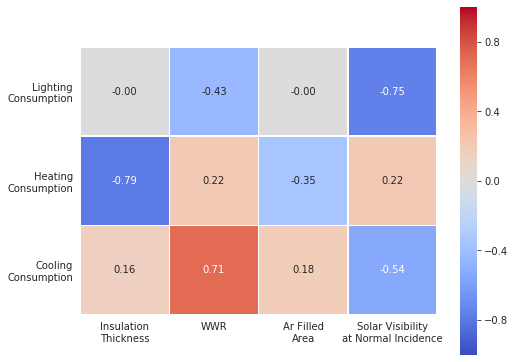

In [5]:
fig=plt.figure(figsize=(8, 8))
outputs2 = outputs.drop(columns=['Argon1', 'Visibility1']).rename(columns={
    'Visibility2':'Solar Visibility\nat Normal Incidence',
    'Argon2':'Ar Filled\nArea',
    'Window to Wall Ratio':'WWR',
    'Insulation Thickness':'Insulation\nThickness',
    'DistrictCooling:Facility':'Cooling\nConsumption',
    'DistrictHeating:Facility':'Heating\nConsumption',
    'InteriorLights:Electricity':'Lighting\nConsumption'
})
temp = temp = outputs2.corr()
temp = temp.drop(columns=['Cooling\nConsumption','Heating\nConsumption','Lighting\nConsumption'])
temp = temp.drop(['Ar Filled\nArea', 'Insulation\nThickness', 'WWR', 'Solar Visibility\nat Normal Incidence'])
cmap = LinearSegmentedColormap.from_list(
    name='hm',
    colors=['lightgreen','white','salmon']
)
mask = np.zeros_like(temp, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(
        temp, 
        annot=True, 
        fmt='.2f', 
        cmap='coolwarm',
        #cmap = cmap,
        square=True, 
        linewidths=.5, 
        annot_kws={"size": 10}, 
        cbar_kws={"shrink": .8},
        vmin=-1,
        vmax=1
    )
    ax.set_ylim(3, 0, .5)
    plt.yticks(rotation=0) 
    plt.savefig('../fig/heatmap.png', transparent=True)